In [1]:
import pickle
import pandas as pd
from CITEsort.BTreeTraversal import BTreeTraversal
from CITEsort.Visualize import plot_keymarker,visualize_tree
import matplotlib
#import numpy as np
from matplotlib import pyplot as plt

## load data and tree 

In [33]:
data = pd.read_csv('../simulator/ADT_simulator_9_8.csv',header=0,index_col=0)

f = open('CITEsort_out/simulator_9_8/tree.pickle','rb')
tree = pickle.load(f)
f.close()

In [34]:
traversal = BTreeTraversal(tree)

## plot compact tree or complete tree
#### The paramter '--compact' of runing runCITEsort.py will set the tree in compact format. If complete format is needed, plot tree again as below. The filename should no longer be 'tree', or the original tree.pdf will be overwritten.

In [12]:
visualize_tree(tree,data,outpath='./CITEsort_out',filename='tree_complete',compact=False)

/mnt/e/phd_research/cite-sort2/CITE-sort-master


## visualize all markers in a certain node
#### the node ID is just the number before the node name in tree.pdf

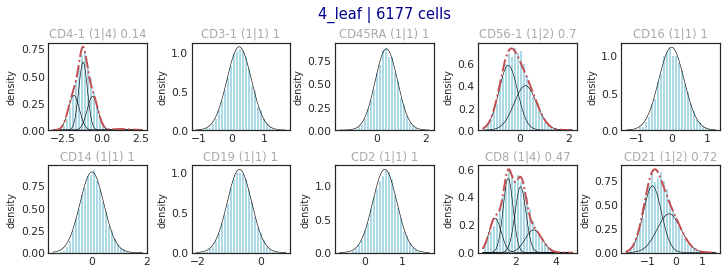

In [45]:
node_ID = 4
traversal.plot_node(data,node_ID,viz_dim=1)

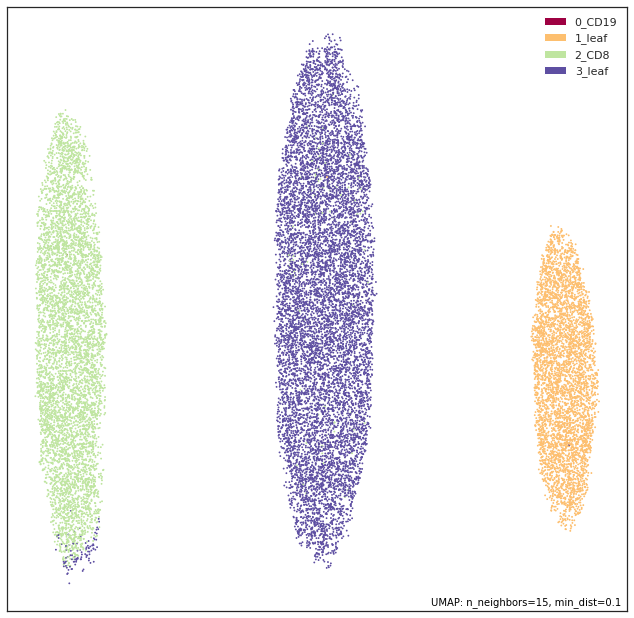

In [37]:
traversal.plot_node_umap(data, nodeID=3)

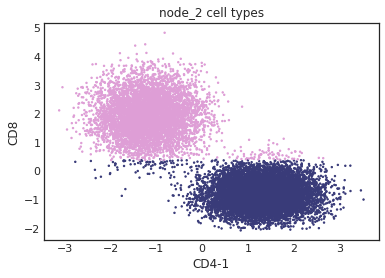

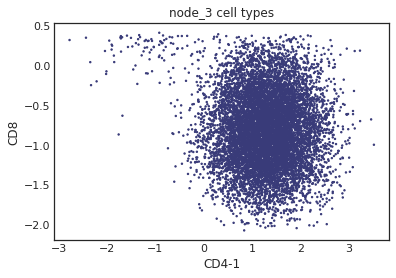

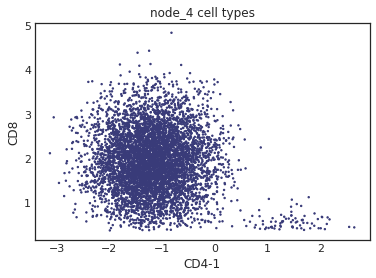

In [42]:
traversal.plot_node_2dim_new(data, 2, 'CD4-1', 'CD8')
traversal.plot_node_2dim_new(data, 3, 'CD4-1', 'CD8')
traversal.plot_node_2dim_new(data, 4, 'CD4-1', 'CD8')

## visualize the key marker in a certain node
#### the node ID is just the number before the node name in tree.pdf

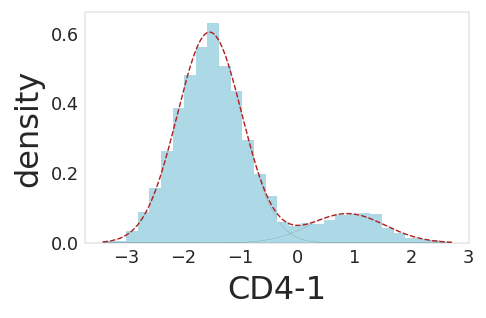

In [7]:
plot_keymarker(data,traversal,node_ID=2,dpi=128)